# Compare double logistic curve fitting with quadratic interpolation

These methods allow us to go from bi-weekly data to daily, but they appraoch the problem differently.

Double logistics code example is taken from: https://stackoverflow.com/questions/77639914/ndvi-double-logistic-curve-fitting-in-python


In [1]:
%matplotlib inline

import sys
import pickle
import warnings
import numpy as np
import xarray as xr
from scipy import stats
import geopandas as gpd
import matplotlib.pyplot as plt

## Analysis Parameters


In [4]:
timeseries_file = '/g/data/os22/chad_tmp/Aus_phenology/data/ecoregions_NDVI_timeseries.pkl'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/Ecoregions2017_modified.geojson'

## Open data

In [5]:
with open(timeseries_file, 'rb') as f:
    results = pickle.load(f)

gdf = gpd.read_file(ecoregions_file)

## Test double logistic curve fitting on seasonal cycle

<!-- import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def double_logistic_function(t, wNDVI, mNDVI, S, A, mS, mA):
    sigmoid1 = 1 / (1 + np.exp(-mS * (t - S)))
    sigmoid2 = 1 / (1 + np.exp(mA * (t - A)))
    seasonal_term = sigmoid1 + sigmoid2 - 1
    return wNDVI + (mNDVI - wNDVI) * seasonal_term

def weight_function(t, S, A, r):
    tr = 100 * (t - S) / (A - S)
    tr = np.clip(tr, 0, 100)
    return np.exp(-np.abs(r) / (1 + tr / 10))

def fit_curve(t, ndvi_observed):
    initial_guess = [np.min(ndvi_observed), np.max(ndvi_observed), np.mean(t), np.mean(t), 1, 1]
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, maxfev=10000)
    residuals = ndvi_observed - double_logistic_function(t, *params)
    weights = weight_function(t, params[2], params[3], residuals)
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, sigma=weights, maxfev=10000)
    return params

doys = ndvi_cycle.time.dt.dayofyear.values[2:]
doys_frac = doys/365
values = ndvi_cycle.values[2:]

##Fit the curve
parameters = fit_curve(doys_frac, values)

##Plot the observed NDVI values
plt.scatter(doys, values, label='Observed NDVI')

##Generate points for the fitted curve
t_fit = np.linspace(min(doys_frac), max(doys_frac), 365)
ndvi_fit = double_logistic_function(t_fit, *parameters)

##Plot the fitted curve
plt.plot(t_fit*365, ndvi_fit, label='Fitted Curve', color='red')

plt.xlabel('Day of the Year')
plt.ylabel('NDVI')
plt.legend()
plt.title('Double Logistic Curve Fitting for NDVI Observations')
plt.show() -->


<!-- def xr_count_peaks(ds, order=16):
    def _find_peaks(ds):
        peaks = scipy.signal.argrelextrema(ds, np.greater, order=order)
        # peaks = scipy.signal.find_peaks(ds, height=0.2, distance=order)
        return len(peaks[0])
    
    ds_n_peaks = xr.apply_ufunc(_find_peaks,
                              ds, 
                              input_core_dims=[['time']],
                              vectorize=True, 
                              dask='parallelized',
                              output_dtypes=[np.float32]
                             )

    return ds_n_peaks.rename('n_peaks')

%%time
n_peaks = xr_count_peaks(ds_smooth.sel(time=slice('2004-09', '2006-03'))) -->

In [6]:
from scipy.optimize import curve_fit

def double_logistic_function(t, wNDVI, mNDVI, S, A, mS, mA):
    sigmoid1 = 1 / (1 + np.exp(-mS * (t - S)))
    sigmoid2 = 1 / (1 + np.exp(mA * (t - A)))
    seasonal_term = sigmoid1 + sigmoid2 - 1
    return wNDVI + (mNDVI - wNDVI) * seasonal_term

def weight_function(t, S, A, r):
    tr = 100 * (t - S) / (A - S)
    tr = np.clip(tr, 0, 100)
    return np.exp(-np.abs(r) / (1 + tr / 10))

def fit_curve(t, ndvi_observed):
    initial_guess = [np.min(ndvi_observed), np.max(ndvi_observed), np.mean(t), np.mean(t), 1, 1]
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, maxfev=10000)
    residuals = ndvi_observed - double_logistic_function(t, *params)
    weights = weight_function(t, params[2], params[3], residuals)
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, sigma=weights, maxfev=10000)
    return params

### Extract a time series to test with

In [7]:
# l = list(results.keys())
# l.sort()
# l

In [8]:
k = 'Jarrah-Karri forest and shrublands'
ndvi_cycle = results[k].sel(time=slice('2002-02', '2002-12')).resample(time='ME').mean()

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


## Fit curves

In [9]:
doys = ndvi_cycle.time.dt.dayofyear.values#[2:]
doys_frac = doys/365
values = ndvi_cycle.values#[2:]

##Fit the curve
parameters = fit_curve(doys_frac, values)

##Generate points for the fitted curve
t_fit = np.linspace(min(doys_frac), max(doys_frac), 365)
ndvi_fit = double_logistic_function(t_fit, *parameters)

#compare with quadratic
quad = ndvi_cycle.dropna(dim='time', how='all').resample(time='1D').interpolate(kind='cubic')



/jobfs/119510324.gadi-pbs/ipykernel_509531/2141155704.py:5: RuntimeWarning: overflow encountered in exp
  sigmoid2 = 1 / (1 + np.exp(mA * (t - A)))


## Plot

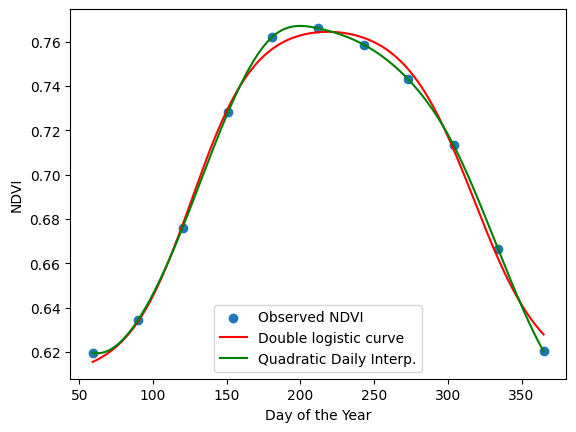

In [11]:
plt.scatter(doys, values, label='Observed NDVI')
plt.plot(t_fit*365, ndvi_fit, label='Double logistic curve', color='red')
plt.plot(quad.time.dt.dayofyear, quad.values, label='Quadratic Daily Interp.', color='green')
plt.xlabel('Day of the Year')
plt.ylabel('NDVI')
plt.legend()
# plt.title('Double Logistic Curve Fitting for NDVI Observations')
plt.show()